# Descriptive analyses that look at previous school year

- Base rates of absences for PAP
- Truancy rates at the school level in prior school year
- Distribution of letter delivery times

In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import us
from plotnine import *

from suso.utils import here

warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = here("data")

# Step 0: define postgres functions

For now, just copied postgres functions from other script before making into a module

In [3]:
def data_endofyear_outcomes(data: pd.DataFrame) -> pd.DataFrame:
    """
    Get the last entry for each studenty by day
    """
    return data.sort_values(by=["usi", "AttendanceDate"]).drop_duplicates(
        ["usi"], keep="last"
    )

# Descriptives: for PAP

- Chronic absenteeism
- Truancy

- Haven't yet merged with SUSO
- Might want to do filtering in initial join to only count with sy_end_date
- Merge with student attributes

## Outcomes in previous school year (to get baselines for PAP)

In [4]:
public_attendance_sy1617 = pd.read_parquet(
    DATA_DIR / "dcps_sy1617_attendanceoutcomes_suso.parquet"
)

In [5]:
charter_attendance_sy1617 = pd.read_parquet(
    DATA_DIR / "charter_sy1617_attendanceoutcomes_suso.parquet"
)

In [6]:
## for now, just remove students in both since
## this analysis is just rough estimates for PAP
usi_both_sy1617 = set(public_attendance_sy1617.usi).intersection(
    set(charter_attendance_sy1617.usi)
)
print(
    str(len(usi_both_sy1617))
    + " students present in both dcps and pcs over the course of\nthe 2016-2017 school year"
)

## remove those students
attendance_both_sy1617_init = pd.concat(
    [public_attendance_sy1617, charter_attendance_sy1617]
)
attendance_both_sy1617 = attendance_both_sy1617_init.loc[
    ~attendance_both_sy1617_init.usi.isin(usi_both_sy1617)
].copy()

31 students present in both dcps and pcs over the course of
the 2016-2017 school year


In [7]:
attendance_endofyear_sy1617 = data_endofyear_outcomes(attendance_both_sy1617)
attendance_endofyear_sy1617.describe()
## to get base rate, take mean count of unexcused absences
## and divide by mean of number of school days
(
    np.mean(attendance_endofyear_sy1617.total_unexcused)
    / np.mean(attendance_endofyear_sy1617.total_schooldays)
) * 10

0.6179496571325245

In [8]:
attendance_endofyear_sy1617_inschools = attendance_endofyear_sy1617.copy()

## Visualizations of truancy in prior school years

### Histogram of unexcused absences (just students who ended up in suso intervention)

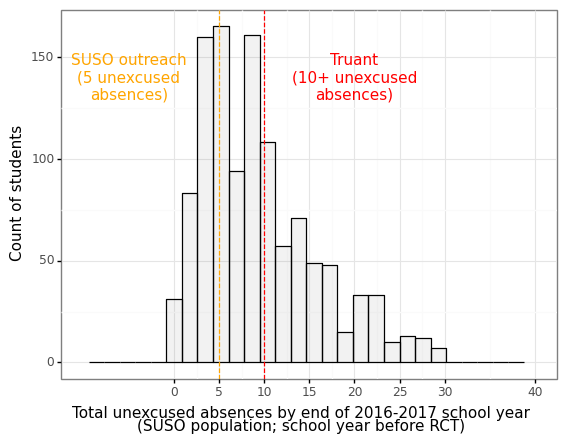

<ggplot: (328780002)>

In [9]:
(
    ggplot(
        attendance_endofyear_sy1617[attendance_endofyear_sy1617.total_unexcused < 30],
        aes(x="total_unexcused"),
    )
    + geom_histogram(bins=30, fill="gray", color="black", alpha=0.1)
    + theme_bw()
    + xlab(
        "Total unexcused absences by end of 2016-2017 school year\n(SUSO population; school year before RCT)"
    )
    + ylab("Count of students")
    + geom_vline(
        xintercept=(5, 10), linetype=("dashed", "solid"), color=("orange", "red")
    )
    + annotate(
        "text",
        x=(-5, 20),
        y=140,
        label=(
            "SUSO outreach\n(5 unexcused\nabsences)",
            "Truant\n(10+ unexcused\nabsences)",
        ),
        color=("orange", "red"),
    )
    + scale_x_continuous(
        breaks=(0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80), limits=(-10, 40)
    )
)

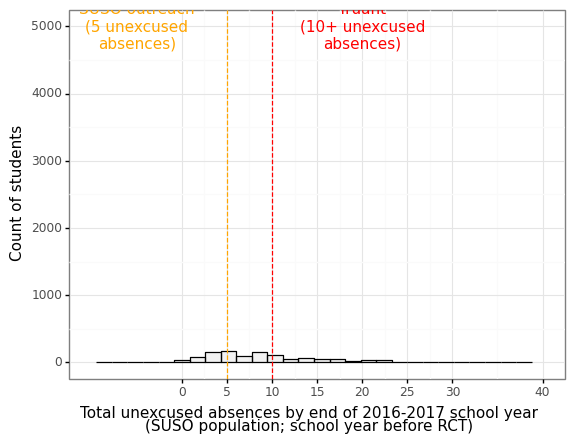

<ggplot: (328777373)>

In [10]:
# TODO(khw): The relevant table doesn't exist in the code

(
    ggplot(
        attendance_endofyear_sy1617_inschools[
            attendance_endofyear_sy1617_inschools.total_unexcused < 30
        ],
        aes(x="total_unexcused"),
    )
    + geom_histogram(bins=30, fill="gray", color="black", alpha=0.1)
    + theme_bw()
    + xlab(
        "Total unexcused absences by end of 2016-2017 school year\n(SUSO population; school year before RCT)"
    )
    + ylab("Count of students")
    + geom_vline(
        xintercept=(5, 10), linetype=("dashed", "solid"), color=("orange", "red")
    )
    + annotate(
        "text",
        x=(-5, 20),
        y=5000,
        label=(
            "SUSO outreach\n(5 unexcused\nabsences)",
            "Truant\n(10+ unexcused\nabsences)",
        ),
        color=("orange", "red"),
    )
    + scale_x_continuous(
        breaks=(0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80), limits=(-10, 40)
    )
)

### Map of truancy rates at suso schools in school year prior

In [11]:
from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import ColumnDataSource, figure

output_notebook()
import geopandas as gpd
from bokeh.io import output_file, output_notebook, show
from bokeh.models import ColorBar, GeoJSONDataSource, LinearColorMapper
from bokeh.palettes import brewer
from bokeh.plotting import figure

Loading BokehJS ...

In [12]:
def getGeometryCoords(row, geom, coord_type, shape_type):
    """
    Returns the coordinates ('x' or 'y') of edges of a Polygon exterior.

    :param: (GeoPandas Series) row : The row of each of the GeoPandas DataFrame.
    :param: (str) geom : The column name.
    :param: (str) coord_type : Whether it's 'x' or 'y' coordinate.
    :param: (str) shape_type
    """

    # Parse the exterior of the coordinate
    if shape_type == "polygon":
        exterior = row[geom].geoms[0].exterior
        if coord_type == "x":
            # Get the x coordinates of the exterior
            return list(exterior.coords.xy[0])

        elif coord_type == "y":
            # Get the y coordinates of the exterior
            return list(exterior.coords.xy[1])

    elif shape_type == "point":
        exterior = row[geom]

        if coord_type == "x":
            # Get the x coordinates of the exterior
            return exterior.coords.xy[0][0]

        elif coord_type == "y":
            # Get the y coordinates of the exterior
            return exterior.coords.xy[1][0]

In [13]:
## merge and subset school absences with location
public_schools = gpd.read_file(DATA_DIR / "Public_Schools.geojson")[
    ["NAME", "ADDRESS", "geometry"]
]
charter_schools = gpd.read_file(DATA_DIR / "Charter_Schools.geojson")[
    ["NAME", "ADDRESS", "geometry"]
]
schools = pd.concat((public_schools, charter_schools), axis=0)
# schools.crs = {'init': 'epsg:4326'}
# schools = schools.to_crs({'init': 'epsg:2248'})
school_locations = pd.read_csv(DATA_DIR / "school_locations.csv")
school_locations = schools.merge(
    school_locations, how="inner", left_on="ADDRESS", right_on="address"
)


school_locations["x"] = school_locations.apply(
    getGeometryCoords, geom="geometry", coord_type="x", shape_type="point", axis=1
)
school_locations["y"] = school_locations.apply(
    getGeometryCoords, geom="geometry", coord_type="y", shape_type="point", axis=1
)

school_locations.head()

## percentage truant at each school
school_truancyrate = attendance_endofyear_sy1617_inschools.groupby(
    "Enr_SchoolName"
).agg({"truant_indicator": np.mean})
school_truancyrate["Enr_SchoolName_tomerge"] = school_truancyrate.index

## left join onto school locations
school_locations_wtruancy = pd.merge(
    school_locations,
    school_truancyrate,
    left_on="NAME",
    right_on="Enr_SchoolName_tomerge",
    how="left",
)
school_locations_wtruancy.head()

,NAME,ADDRESS,geometry,school_name,address,x,y,truant_indicator,Enr_SchoolName_tomerge
0,Leckie Elementary School,4201 MARTIN LUTHER KING JR AVENUE SW,POINT (-77.01289 38.82820),Leckie ES,4201 MARTIN LUTHER KING JR AVENUE SW,-77.012894,38.828204,NaN,NaN
1,Stanton Elementary School,2701 NAYLOR ROAD SE,POINT (-76.96849 38.85928),Stanton ES,2701 NAYLOR ROAD SE,-76.968492,38.859280,0.337349,Stanton Elementary School
2,Kramer Middle School,1700 Q STREET SE,POINT (-76.98017 38.87129),Kramer MS,1700 Q STREET SE,-76.980174,38.871294,0.210526,Kramer Middle School
3,Savoy Elementary School,2400 SHANNON PLACE SE,POINT (-76.99361 38.86286),Savoy ES,2400 SHANNON PLACE SE,-76.993607,38.862859,0.500000,Savoy Elementary School
4,Thomas Elementary School,650 ANACOSTIA AVENUE NE,POINT (-76.95211 38.90129),Thomas ES,650 ANACOSTIA AVENUE NE,-76.952113,38.901286,0.750000,Thomas Elementary School


In [14]:
school_locations_wtruancy_complete = school_locations_wtruancy.loc[
    school_locations_wtruancy.truant_indicator.notnull()
].copy()
school_locations_wabsences_bottom = school_locations_wtruancy_complete.loc[
    (school_locations_wtruancy_complete.truant_indicator < 0.2)
].copy()
school_locations_wabsences_middle = school_locations_wtruancy_complete.loc[
    (school_locations_wtruancy_complete.truant_indicator >= 0.2)
    & (school_locations_wtruancy_complete.truant_indicator < 0.4)
].copy()
school_locations_wabsences_high = school_locations_wtruancy_complete.loc[
    (school_locations_wtruancy_complete.truant_indicator >= 0.4)
].copy()

In [15]:
from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import ColumnDataSource, figure

output_notebook()
import geopandas as gpd
from bokeh.io import output_file, output_notebook, show
from bokeh.models import ColorBar, GeoJSONDataSource, LinearColorMapper
from bokeh.palettes import brewer
from bokeh.plotting import figure

## load census tracts
dc_tracts = gpd.read_file(us.states.DC.shapefile_urls("tract"))

## trasnform geopandas into gson
import json

dc_tracts_json = json.loads(dc_tracts.to_json())
dc_tracts_json_data = json.dumps(dc_tracts_json)
geosource = GeoJSONDataSource(geojson=dc_tracts_json_data)

## use column data source to make school locations usable
schools_bokeh_low = ColumnDataSource(
    data=dict(
        x=school_locations_wabsences_bottom["x"],
        y=school_locations_wabsences_bottom["y"],
        name=school_locations_wabsences_bottom["school_name"].values,
        percent_truant=school_locations_wabsences_bottom["truant_indicator"].values
        * 30,
    )
)
schools_bokeh_med = ColumnDataSource(
    data=dict(
        x=school_locations_wabsences_middle["x"],
        y=school_locations_wabsences_middle["y"],
        name=school_locations_wabsences_middle["school_name"].values,
        percent_truant=school_locations_wabsences_middle["truant_indicator"].values
        * 30,
    )
)
schools_bokeh_high = ColumnDataSource(
    data=dict(
        x=school_locations_wabsences_high["x"],
        y=school_locations_wabsences_high["y"],
        name=school_locations_wabsences_high["school_name"].values,
        percent_truant=school_locations_wabsences_high["truant_indicator"].values * 30,
    )
)


## source for remainder: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

Loading BokehJS ...

In [16]:
palette = brewer["Blues"][8]
# Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette=palette, low=20000, high=100000)
# Define custom tick labels for color bar.
tick_labels = {
    "20000": "$20,000",
    "30000": "$30,000",
    "40000": "$40,000",
    "50000": "$50,000",
    "60000": "$60,000",
    "70000": "$70,000",
    "80000": "$80,000",
    "90000": "$90,000",
    "100000": "$100,000",
}
# Create color bar.
color_bar = ColorBar(
    color_mapper=color_mapper,
    label_standoff=8,
    border_line_color=None,
    location=(0, 0),
    orientation="horizontal",
    major_label_overrides=tick_labels,
)


shading_fig = figure(
    title="Truancy rates v. local demographics: Schools in Show Up, Stand Out (2016-2017 school year)"
)


## background of tract median income
shading_fig.patches(
    "xs",
    "ys",
    source=geosource,
    fill_color={"field": "FAGI_MEDIAN_2015", "transform": color_mapper},
    line_color="black",
    line_width=0.25,
    fill_alpha=0.8,
)
shading_fig.xgrid.grid_line_color = None
shading_fig.ygrid.grid_line_color = None
shading_fig.axis.visible = False
shading_fig.circle(
    "x", "y", source=schools_bokeh_low, size=8, color="green", fill_alpha=0.8
)
shading_fig.circle(
    "x", "y", source=schools_bokeh_med, size=8, color="#595959", fill_alpha=0.8
)
shading_fig.circle(
    "x", "y", source=schools_bokeh_high, size=8, color="#dc4057", fill_alpha=0.8
)

## overlay of schools
shading_fig.add_layout(color_bar, "below")
shading_fig.quad(
    left=[-77.16],
    top=[38.87],
    right=[-77.05],
    bottom=[38.81],
    color="white",
    line_color="black",
    alpha=1,
)
shading_fig.text(
    x=[-77.155, -77.13, -77.155, -77.13, -77.155, -77.13, -77.155, -77.13],
    y=[38.85, 38.85, 38.84, 38.84, 38.83, 38.83, 38.82, 38.82],
    text=[
        "Blue\nshading:",
        "Median household income\n(2010 census)",
        "Green:",
        "<20% of students truant",
        "Gray:",
        "20-40% of students truant",
        "Pink:",
        ">40% of students truant",
    ],
    text_color=[
        "blue",
        "black",
        "green",
        "black",
        "#595959",
        "black",
        "#dc4057",
        "black",
    ],
    angle=0,
    text_font_size="10pt",
    text_font="Montserrat",
)


output_notebook()
# Display figure.
show(shading_fig)

Loading BokehJS ...

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "text_font" value "Montserrat" [renderer: GlyphRenderer(id='1077', ...)]


## Letter delivery time patterns to determine when to start counting absences

In [17]:
df_suso = pd.read_csv(DATA_DIR / "df_suso_merged.csv")
df_suso["delivery_date"] = pd.to_datetime(df_suso["status_datetime"]).dt.round("D")
df_suso["eligibility_date"] = pd.to_datetime(df_suso["referral_date"]).dt.round("D")
df_suso["delivery_time"] = df_suso["delivery_date"] - df_suso["eligibility_date"]

In [18]:
df_suso[(df_suso.is_treatment == True) & (df_suso.status_datetime.notnull())].shape

(602, 65)

In [19]:
df_suso_validdelivery = df_suso.loc[
    (df_suso.delivery_time.notnull())
    & (df_suso.delivery_time < "30 days")
    & (df_suso.delivery_time > "0 days")
].copy()
(
    ggplot(df_suso_validdelivery, aes(x="delivery_time"))
    + geom_histogram(fill="red", alpha=0.3, color="black")
    + theme_bw()
)

df_suso.delivery_time.describe()

count                           602
mean     24 days 16:47:02.591362126
std      83 days 14:17:39.626565496
min              -90 days +00:00:00
25%                 5 days 00:00:00
50%                 7 days 00:00:00
75%                17 days 00:00:00
max               892 days 00:00:00
Name: delivery_time, dtype: object